In [2]:
!pip install xgboost
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_validate, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
import warnings
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Create artifacts directory
os.makedirs("artifacts", exist_ok=True)

def preprocess_data(path='loan_prediction.csv'):
    data = pd.read_csv(path)
    
    # Handle missing values
    data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)
    data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean(), inplace=True)
    data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
    data['Married'].fillna(data['Married'].mode()[0], inplace=True)
    data['Dependents'] = data['Dependents'].replace('3+', '4')
    data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
    data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace=True)
    data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace=True)

    # Drop Loan_ID and separate target
    data.drop('Loan_ID', axis=1, inplace=True)
    data['Loan_Status'] = data['Loan_Status'].map({'Y': 1, 'N': 0})
    
    # Balance the classes
    majority = data[data['Loan_Status'] == 1]
    minority = data[data['Loan_Status'] == 0]
    minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
    data_balanced = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)
    
    y = data_balanced['Loan_Status']
    X = data_balanced.drop('Loan_Status', axis=1)
    X = pd.get_dummies(X, drop_first=True)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler, X.columns


def evaluate_model(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(model, X, y, cv=kf, scoring=scoring)

    mean_scores = {metric: results[f'test_{metric}'].mean() for metric in scoring}
    return mean_scores


def save_confusion_matrix(y_true, y_pred, model_name, class_names):
    """Save confusion matrix as plot and numpy array"""
    cm = confusion_matrix(y_true, y_pred)
    
    # Save plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f'artifacts/confusion_matrix_{model_name}.png')
    plt.close()
    
    # Save numpy array
    np.save(f'artifacts/confusion_matrix_{model_name}.npy', cm)
    return cm


# --- Main Execution ---
def main():
    X, y, scaler, feature_names = preprocess_data()
    class_names = np.unique(y).astype(str)

    models = {
        "LogisticRegression": (
            LogisticRegression(),
            {"C": [0.01, 0.1, 1, 10]}
        ),
        "DecisionTree": (
            DecisionTreeClassifier(),
            {"max_depth": [3, 5, 10, None]}
        ),
        "RandomForest": (
            RandomForestClassifier(),
            {
                "n_estimators": [100, 200, 300],
                "max_depth": [5, 10, None],
                "min_samples_split": [2, 5, 10]
            }
        ),
        "GradientBoosting": (
            GradientBoostingClassifier(),
            {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]}
        ),
        "KNN": (
            KNeighborsClassifier(),
            {"n_neighbors": [3, 5, 7]}
        ),
        "XGBoost": (
            XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1], "max_depth": [3, 5, 7]}
        )
    }

    best_models = {}
    model_metrics = {}
    confusion_matrices = {}

    for name, (model, params) in models.items():
        print(f"\n--- Tuning and Evaluating: {name} ---")
        best_model = tune_model(model, params, X, y)
        metrics = evaluate_model(best_model, X, y)
        model_metrics[name] = metrics

        # Cross-validated predictions
        y_pred = cross_val_predict(best_model, X, y, cv=5)
        
        # Save confusion matrix
        cm = save_confusion_matrix(y, y_pred, name, class_names)
        confusion_matrices[name] = cm
        
        print(f"\n📊 {name} Metrics:")
        for metric, score in metrics.items():
            print(f"{metric.capitalize()}: {score:.4f}")
        
        # Save Random Forest metrics separately
        if name == "RandomForest":
            joblib.dump(metrics, 'artifacts/random_forest_metrics.pkl')
            print("\n💾 Saved Random Forest metrics to 'artifacts/random_forest_metrics.pkl'")
        
        best_models[name] = best_model

    # Find best model
    best_model_name = max(model_metrics, key=lambda k: model_metrics[k]['f1'])
    final_model = best_models[best_model_name]
    best_metrics = model_metrics[best_model_name]
    
    print(f"\n✅ Best model: {best_model_name} with F1={best_metrics['f1']:.4f}")

    # Save final artifacts
    joblib.dump(final_model, 'best_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(feature_names, 'feature_names.pkl')
    joblib.dump(best_metrics, 'metrics.pkl')
    joblib.dump(model_metrics, 'artifacts/all_metrics.pkl')
    
    # Save best model confusion matrix separately
    np.save('artifacts/best_model_confusion_matrix.npy', confusion_matrices[best_model_name])
    print("\n💾 Saved artifacts:")
    print("- best_model.pkl, scaler.pkl, feature_names.pkl")
    print(f"- Confusion matrices and metrics in 'artifacts/' directory")

    return final_model, scaler, feature_names


def tune_model(model, param_dist, X, y):
    total_combinations = 1
    for v in param_dist.values():
        total_combinations *= len(v)
    n_iter = min(10, total_combinations)

    rs = RandomizedSearchCV(model, param_distributions=param_dist, 
                           n_iter=n_iter, cv=5, scoring='f1', random_state=42)
    rs.fit(X, y)
    return rs.best_estimator_

if __name__ == "__main__":
    model, scaler, columns = main()

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels

--- Tuning and Evaluating: LogisticRegression ---

📊 LogisticRegression Metrics:
Accuracy: 0.7417
Precision: 0.6932
Recall: 0.8715
F1: 0.7707

--- Tuning and Evaluating: DecisionTree ---

📊 DecisionTree Metrics:
Accuracy: 0.8389
Precision: 0.8892
Recall: 0.7702
F1: 0.8250

--- Tuning and Evaluating: RandomForest ---

📊 RandomForest Metrics:
Accuracy: 0.8851
Precision: 0.8705
Recall: 0.9056
F1: 0.8866

💾 Saved Random Forest metrics to 'artifacts/random_forest_metrics.pkl'

--- Tuning and Evaluating: GradientBoosting ---

📊 GradientBoosting Metrics:
Accuracy: 0.8258
Precision: 0.7933
Recall: 0.8817
F1: 0.8345

--- Tuning and Evaluating: KNN ---

📊 KNN Metrics:
Accuracy: 0.8009
Precision: 0.8123
Recall: 0.7825
F1: 0.7965

--- Tuning and Evaluating: XGBoost ---

📊 XGBoost Metrics:
Accuracy: 0.8839
Precision: 0.8867
Recall: 0.8788
F1: 0.8826

✅ Best model: RandomForest with

In [3]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Load saved artifacts
model = joblib.load('best_model.pkl')
scaler = joblib.load('scaler.pkl')
columns = joblib.load('feature_names.pkl')
metrics = joblib.load('metrics.pkl')

# Load Random Forest metrics
rf_metrics = joblib.load('artifacts/random_forest_metrics.pkl')
print("\n📊 Random Forest Metrics:")
for metric, score in rf_metrics.items():
    print(f"{metric.capitalize()}: {score:.4f}")

def predict_and_report(sample, true_label=None):
    sample = sample.copy()
    sample['Dependents'] = int(sample.get('Dependents', 0))
    
    df_input = pd.DataFrame([sample])
    
    # Ensure all expected columns exist
    for col in columns:
        if col not in df_input.columns:
            df_input[col] = 0
    
    # Align column order
    df_input = df_input[columns]
    
    # Scale the input
    X_input_scaled = scaler.transform(df_input)
    
    # Predict
    pred = model.predict(X_input_scaled)
    pred_proba = model.predict_proba(X_input_scaled)
    
    # Output
    status = "Approved ✅" if pred[0] == 1 else "Rejected ❌"
    confidence = pred_proba[0][pred[0]] * 100
    print(f"\n📌 Prediction: {status} (Confidence: {confidence:.1f}%)")
    
    # Model metrics
    print(f"\n📊 Best Model Performance:")
    print(f"Accuracy : {metrics['accuracy'] * 100:.2f}%")
    print(f"Precision: {metrics['precision'] * 100:.2f}%")
    print(f"Recall   : {metrics['recall'] * 100:.2f}%")
    print(f"F1 Score : {metrics['f1'] * 100:.2f}%")

# Example usage
sample = {
    'ApplicantIncome': 1000,
    'CoapplicantIncome': 500,
    'LoanAmount': 200,
    'Loan_Amount_Term': 360.0,
    'Credit_History': 1.0,
    'Dependents': 1,
    'Gender_Male': 1,
    'Married_Yes': 1,
    'Education_Not Graduate': 0,
    'Self_Employed_Yes': 0,
    'Property_Area_Semiurban': 1,
    'Property_Area_Urban': 0
}

predict_and_report(sample)


📊 Random Forest Metrics:
Accuracy: 0.8851
Precision: 0.8705
Recall: 0.9056
F1: 0.8866

📌 Prediction: Approved ✅ (Confidence: 74.0%)

📊 Best Model Performance:
Accuracy : 88.51%
Precision: 87.05%
Recall   : 90.56%
F1 Score : 88.66%


In [21]:
# Run in a notebook cell
!pip install -U ydata-profiling[notebook] ipywidgets
!jupyter nbextension enable --py widgetsnbextension --user

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.8 MB/s eta 0:00:00.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 4.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.0 MB/s eta 0:00:00 0:00:01
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 13/13 [00:00<00:00, 75.12it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

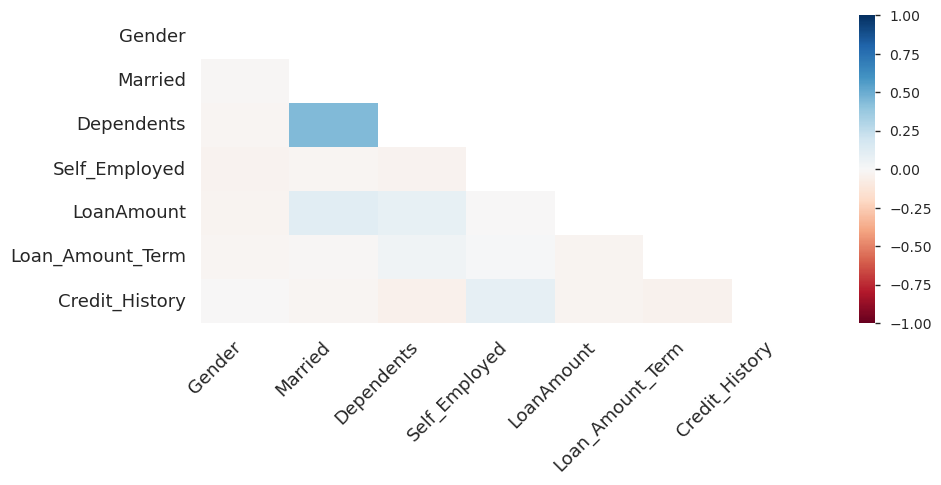

In [4]:
from ydata_profiling import ProfileReport

# Load your dataset
df = pd.read_csv("loan_prediction.csv")

# Generate profile report
profile = ProfileReport(
    df,
    title="Loan Prediction Dataset Report",
    explorative=True,
    interactions={"targets": ["Loan_Status"]},  # Focus on target variable
    correlations={"pearson": {"calculate": True}},
    missing_diagrams={"heatmap": True},
    vars={
        "cat": {"words": False}  # Disable word cloud for categorical vars
    }
)

# Display in notebook (interactive widgets)
#profile.to_widgets()

# Alternative: Save as HTML file
profile.to_file("loan_prediction_report.html")